In [138]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from skbio.tree import TreeNode
from itertools import combinations
from scipy.stats import mannwhitneyu
from skbio.stats.distance import mantel
from glob import glob
from os.path import join, basename
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from ggmap.snippets import *
from ggmap.analyses import *
from ggmap.correlations import *
from ggmap.workflow import *
import calour as ca
ca.set_log_level(40)
import io

import requests
import json
import fetch
from ggmap.tree import *
from ggmap.utils import *
from ggmap.readwrite import *

from scipy.spatial import distance
from scipy.cluster import hierarchy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def _savefig(fig, name):
    os.makedirs('Figures_generated/SVG', exist_ok=True)
    os.makedirs('Figures_generated/PNG', exist_ok=True)
    
    fig.savefig('Figures_generated/SVG/%s.svg' % name, bbox_inches='tight')
    fig.savefig('Figures_generated/PNG/%s.png' % name, bbox_inches='tight')

In [97]:
counts = dict()
meta = pd.read_excel("Incoming/Serum samples for bacterial metabolites analysis - sent on 13-01-2020.xlsx", sheet_name="Murine serum samples").rename(columns={'tube_number': 'sample_name'})
meta['sample_name'] = meta['sample_name'].astype(str)
meta = meta.set_index('sample_name')

x = pd.read_excel('Incoming/200225__Data_20-0005.xlsx', sheet_name="01.AllData").rename(columns={'Sample.label.on.tube': 'sample_name'})
x['sample_name'] = x['sample_name'].astype(str)
data = x[['sample_name', "Compound", "ISTD", "Resp", "ISTD.Resp", "Resp.Ratio", "UserAnno.Peak", "MI.Peak", "MZ", "MZ.Ex.Left", "MZ.Ex.Right", "MZ.Ex.Units", "RT.Compound", "RT.Peak", "MS.Replicates", "data.source", "ISTD.Resp.Ratio", "Acq.Method.Condensed", "MS.project", "Report.Name", "data.dir", "relativeResponse", "IQR_1.5_outlier"]].set_index(['sample_name', 'Compound'])
counts['GC-MS'] = pd.pivot_table(data=data, columns='sample_name', index="Compound", values="relativeResponse").fillna(0)

x = pd.read_excel("Incoming/20-0005_IC-MS_results_filtered.xlsx", sep="\t")
x['Compound'] = x['Name'].fillna('Unknown') + '__' + x['Molecular Weight'].astype(str) + "__" + x['RT [min]'].astype(str)
# attention: I am guessing here how to map sample names. I don't understand why we cannot use ONE set of samplenames throught the different measurements :-/
sample_id_map = {c: c.split('(')[-1][1:-1] for c in x.columns if c.startswith('Norm. Area: 20-0005_')}
x = x.rename(columns=sample_id_map)
counts['IC-MS'] = x[['Compound'] + sorted(list(sample_id_map.values()))].set_index('Compound')
counts['IC-MS'].columns.name = 'sample_name'

# normalize IC and GC to 0-1 intervals and merge
counts['IC+GC-MS'] = pd.concat([(counts[method] - counts[method].min().min()) / (counts[method].max().max() - counts[method].min().min())
                                for method in ['IC-MS', 'GC-MS']], sort=False, join='inner') * 10000

In [106]:
res_alpha = dict()
res_beta = dict()
res_emperor = dict()
res_corr = dict()
sig_cols = dict()

for method in counts.keys():
    res_alpha[method] = alpha_diversity(counts[method], metrics=['shannon'], dry=False, wait=False, rarefaction_depth=None)
    if res_alpha[method]['results'] is not None:
        res_alpha[method]['results'].index = list(map(str, res_alpha[method]['results'].index))

    res_beta[method] = beta_diversity(counts[method], metrics=['bray_curtis', 'jaccard'], dry=False, wait=False)
    if res_beta[method]['results'] is not None:
        res_emperor[method] = emperor(meta, res_beta[method]['results'], fp_results="./Emperor/", dry=False, wait=False, infix='_%s' % method)

    cols_toCheck = ["genotype", "antibiotics_treatment_start_timestamp", "facility", "diseased", "cage", "sex"]
    res_corr[method] = correlation_diversity_metacolumns(meta, cols_toCheck, res_alpha[method]['results'], res_beta[method]['results'],
                                                         dry=False, wait=False)
    if (res_corr[method] is not None) and (res_corr[method]['results'] is not None):
        for col in cols_toCheck:
            sig_cols[(method, col)] = res_corr[method]['results'][res_corr[method]['results']['column'] == col]['p-value'].min() <= 0.05
sig_cols = pd.pivot_table(data=pd.Series(sig_cols).to_frame().reset_index(), index='level_1', columns='level_0', values=0)

res_mantel = dict()
for (methodA, methodB) in combinations(counts.keys(), 2):
    _ = emperor(meta, res_beta[methodA]['results'], fp_results="./Emperor/", other_beta_diversities=res_beta[methodB]['results'], dry=False, wait=False, infix='_%s-%s' % (methodA, methodB), use_grid=True)
    for metric in res_beta[methodA]['results'].keys():
        if metric == 'jaccard':
            # jaccard doesn't make sense, since all compounds are always non zero, i.e. distances are always 0
            continue
        res_mantel[(metric, methodA, methodB)] = mantel(res_beta[methodA]['results'][metric], res_beta[methodB]['results'][metric], strict=False)
res_mantel = pd.DataFrame(res_mantel).T.rename(columns={0: 'corr_coeff', 1: 'p_value', 2: 'n'})

print("Significantly (<=0.05) correlating metadata fields with metabolome:")
display(sig_cols)
print("Mantel correlation between metabolome measures:")
display(res_mantel)

Using existing results from '.anacache/863d46e0d0daa2981a9ec1cbeaf5d11d.adiv'. 
Using existing results from '.anacache/8a60d661a77d7f0c480e7eb4d518879b.bdiv'. 
Using existing results from '.anacache/89d2d00cebfc683218742337414a4c74.emperor'. 
Using existing results from '.anacache/c8b0b77a0a5c9219e0ac1818ec75da75.corr-divmeta'. 
Using existing results from '.anacache/1c2afeda8d80a180454df89de855858a.adiv'. 
Using existing results from '.anacache/988d44d19aea5ba3a517f8200dc42f2f.bdiv'. 
Using existing results from '.anacache/e212395b81815839e0c3512b366d2a46.emperor'. 
Reducing analysis to 30 samples.
Using existing results from '.anacache/920e18aeea69c46739206247432fac19.corr-divmeta'. 
Using existing results from '.anacache/142489ab8fb2b1c2e81c3acd71eb0a4e.adiv'. 
Using existing results from '.anacache/08d4d171811ff4a41668a5e151b05008.bdiv'. 
Using existing results from '.anacache/2ef44d1804f14f5fba222c8e54dbc416.emperor'. 
found matching working dir "/homes/sjanssen/TMP/ana_corr-divme

Significantly (<=0.05) correlating metadata fields with metabolome:


level_0,GC-MS,IC+GC-MS,IC-MS
level_1,,,
antibiotics_treatment_start_timestamp,True,True,True
cage,True,True,True
diseased,True,True,True
facility,False,False,False
genotype,True,True,True
sex,False,False,False


Mantel correlation between metabolome measures:


corr_coeff  p_value     n
bray_curtis GC-MS IC-MS       0.529546    0.001  30.0
                  IC+GC-MS    0.843608    0.001  30.0
            IC-MS IC+GC-MS    0.890655    0.001  30.0

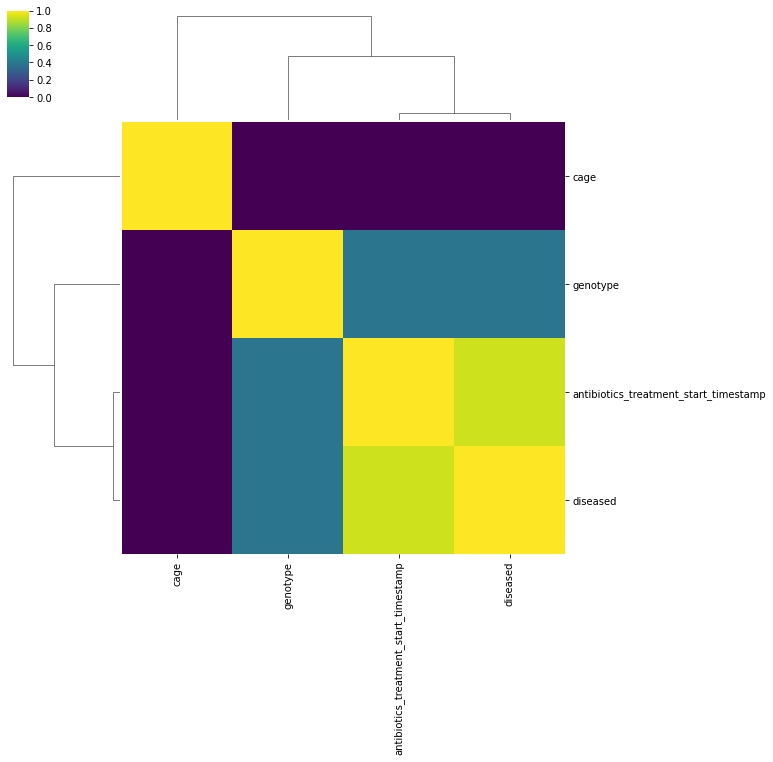

In [62]:
fields_categorials = ["genotype", "antibiotics_treatment_start_timestamp", "diseased", "cage"]
fields_intervals = []
fields_ordinals = {}
res_corr_meta = correlate_metadata(meta.loc[:, cols_significant], fields_categorials, fields_ordinals, fields_intervals)
res_corr_meta[0]

Using existing results from '.anacache/b1e430662bef7417c443ee2028d94bad.fRDAalpha'. 
No significant findings.
Using existing results from '.anacache/2551ddf57450bd71a150734c5befaeda.fRDAbeta'. 
Using existing results from '.anacache/d5af414900e73283a745a0421be93648.fRDAalpha'. 
No significant findings.
Using existing results from '.anacache/f0e75223ea96c72792fdf4b253048834.fRDAbeta'. 
Using existing results from '.anacache/f9b91f74c02c0fdea7cd2a9a63fef232.fRDAalpha'. 
No significant findings.
Using existing results from '.anacache/6d30962884fdf968a052776cfdb5f90d.fRDAbeta'. 


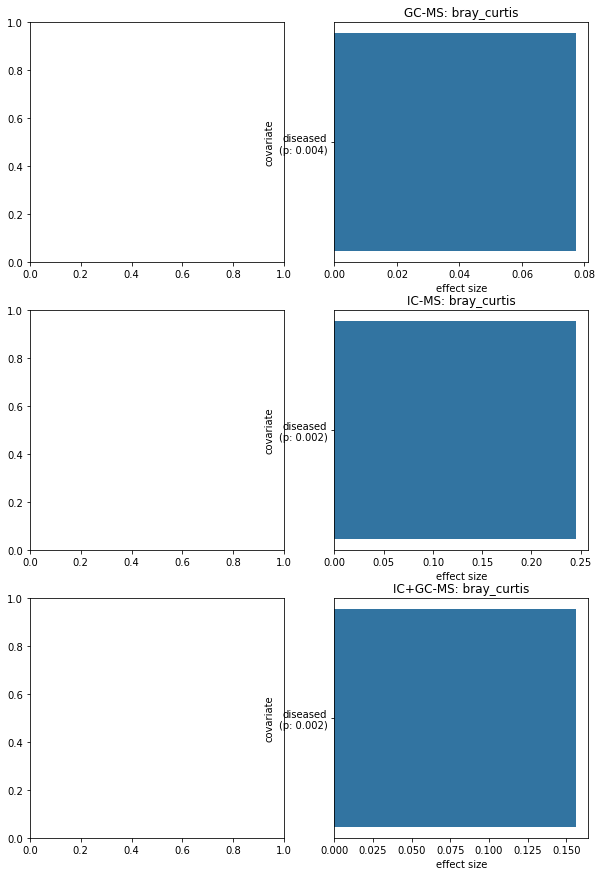

In [129]:
fields = ["diseased", "genotype"]
#fields = [c for c,r in (sig_cols.sum(axis=1) == sig_cols.shape[1]).iteritems() if r]

fig, axes = plt.subplots(len(counts.keys()), 2, figsize=(5*2, 5*len(counts.keys())))
for i, method in enumerate(counts.keys()):
    metric = 'shannon'
    _ = redundancy_analysis_alpha(meta, res_alpha[method]['results'][metric],
                                  categorials=fields, 
                                  ax=axes[i][0], title=metric,
                                  dry=False, wait=False)
    
    metric = 'bray_curtis'
    _ = redundancy_analysis_beta(meta, res_beta[method]['results'][metric], metric,
                                 categorials=fields, 
                                 ax=axes[i][1], title=metric,
                                 dry=False, wait=False)
    axes[i][1].set_title('%s: %s' % (method, metric))
fig

## Specific analyses

In [142]:
e = dict()

fp_meta = 'Workdir/metabolome_diffabund_meta.tsv'
meta.to_csv(fp_meta, sep="\t", index=True)
for method in res_beta.keys():
    fp_diffabund = 'Workdir/metabolome_diffabund_%s.biom' % method
    pandas2biom(fp_diffabund, counts[method])
    e[method] = ca.read_amplicon(fp_diffabund, fp_meta, min_reads=0, normalize=10000)

### Non-diseased animals: difference WT vs. Pax5+/-

In [ ]:
for method in res_beta.keys():
    p = plotNetworks("genotype", meta[meta['diseased'] == 'no'], res_alpha[method]['results'], {k: v for k,v in res_beta[method]['results'].items() if k == 'bray_curtis'}, minnumalpha=5, name='%s: genotype' % method)

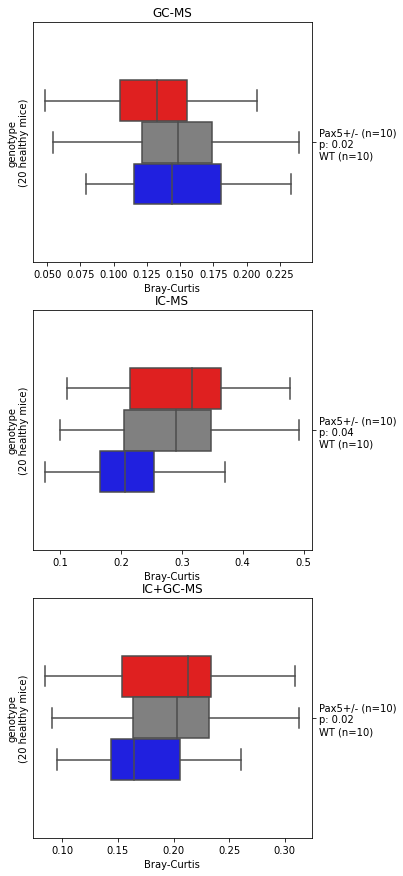

In [194]:
fig, axes = plt.subplots(3,1, figsize=(1*5, 3*5))
for i, method in enumerate(res_beta.keys()):
    field = 'genotype'
    field_meta = meta[meta['diseased'] == 'no'][field]
    b = detect_distant_groups(res_beta[method]['results']['bray_curtis'], 'Bray-Curtis', field_meta)
    ax, _ = plotGroup_permanovas(res_beta[method]['results']['bray_curtis'], field_meta, **b,
                                 horizontal=True, print_sample_numbers=True, colors_boxplot={'between': 'gray', 'left': 'red', 'right': 'blue'}, ax=axes[i])
    ax.set_ylabel(field+ "\n(%i healthy mice)" % field_meta.shape[0])
    ax.yaxis.label.set_visible(True)
    ax.set_title(method)
_savefig(fig, 'metabolome_beta_genotype')

/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'genotype'  (n=30)
     6 (of   56) taxa different between 'WT' (n=10) vs. 'Pax5+/-' (n=10)



/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'genotype'  (n=37)
   107 (of  217) taxa different between 'WT' (n=10) vs. 'Pax5+/-' (n=10)



/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'genotype'  (n=30)
   121 (of  273) taxa different between 'WT' (n=10) vs. 'Pax5+/-' (n=10)



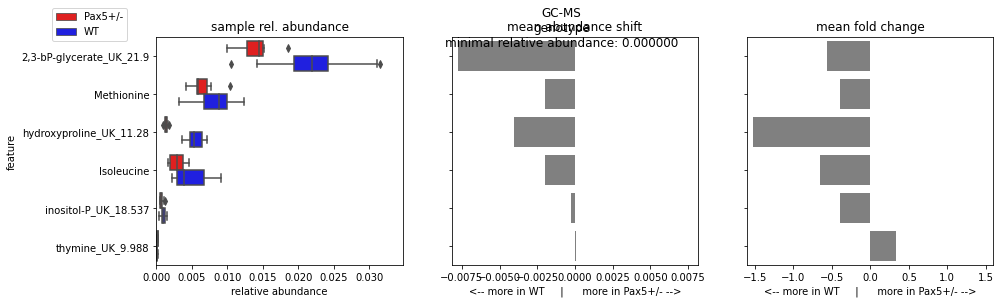

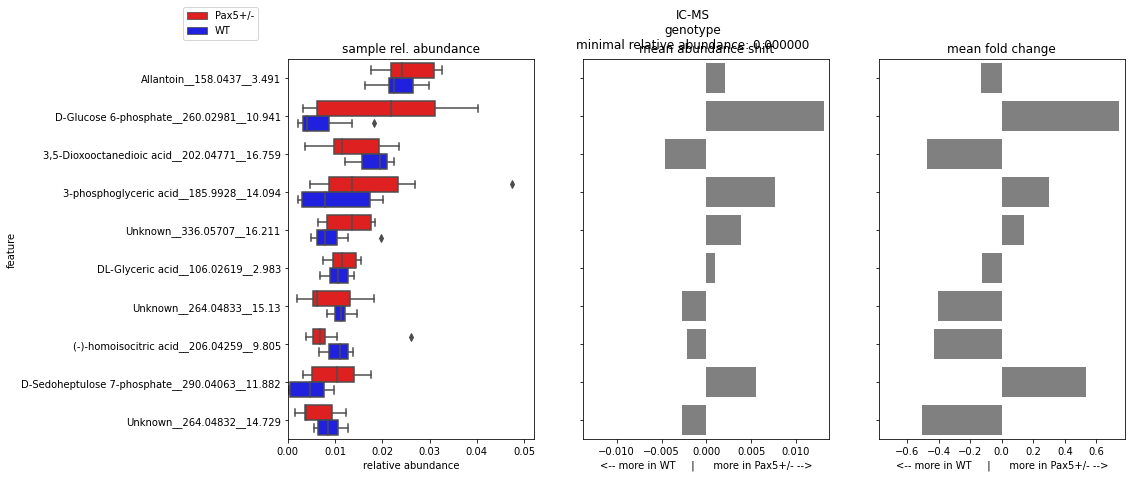

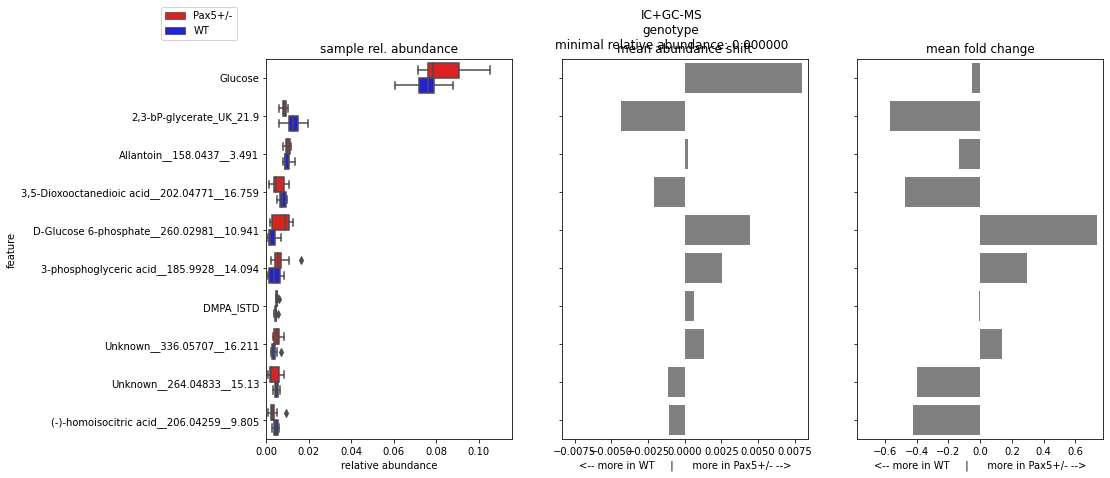

In [196]:
for method in res_beta.keys():
    res_dsFDR_genotype = find_diff_taxa(e[method], meta[meta['diseased'] == 'no'], ['genotype'])
    p = plot_diff_taxa(counts[method], meta[meta['diseased'] == 'no']['genotype'], res_dsFDR_genotype,
                       min_mean_abundance=0.0, title=method, topXfeatures=10,
                       colors_boxplot={'Pax5+/-': 'red', 'WT': 'blue'}, color_barplot='gray')
    _savefig(p[0], 'metabolome_dsfdr_genotype_%s' % method)
    #_savefig(p[0], 'diffabund_genotype')
    #p[0]
    #break

### Pax5+/- animals: sick vs. healthy

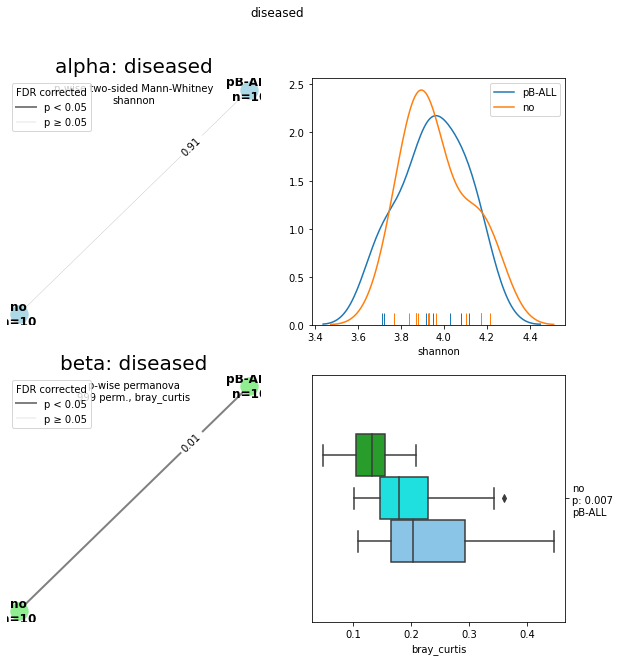

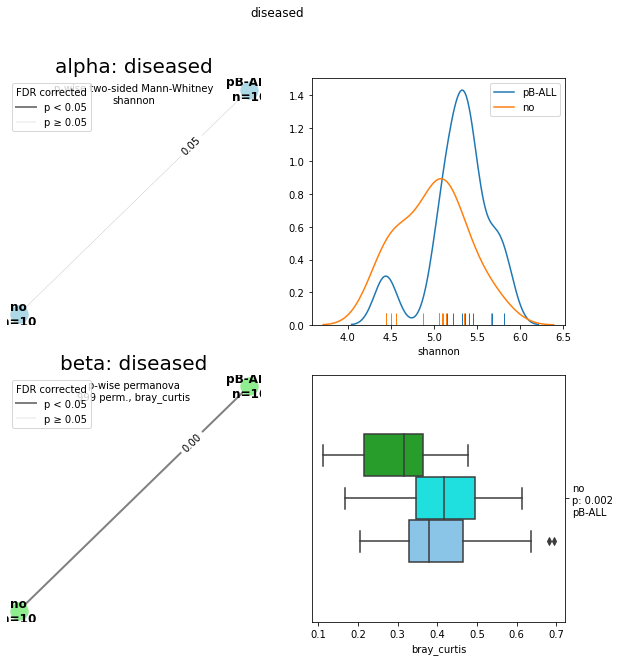

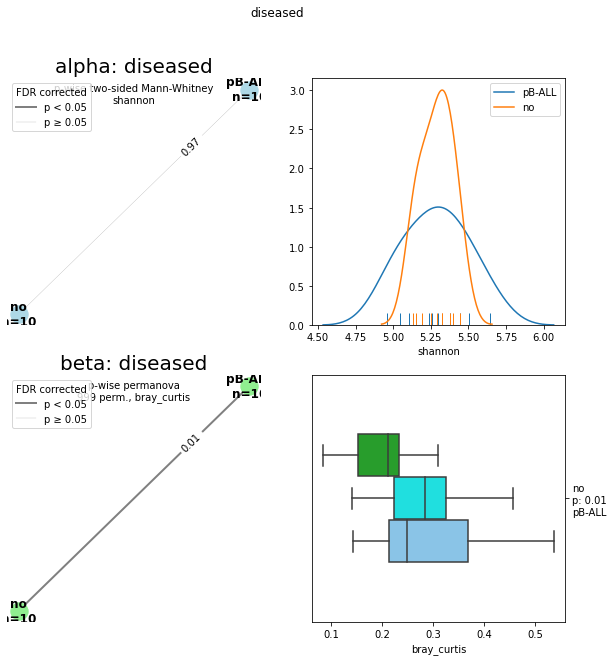

In [140]:
for method in res_beta.keys():
    p = plotNetworks("diseased", meta[meta['genotype'] == 'Pax5+/-'], res_alpha[method]['results'], {k: v for k,v in res_beta[method]['results'].items() if k == 'bray_curtis'}, minnumalpha=5, name='diseased')
    #_savefig(p, 'network_diseased')

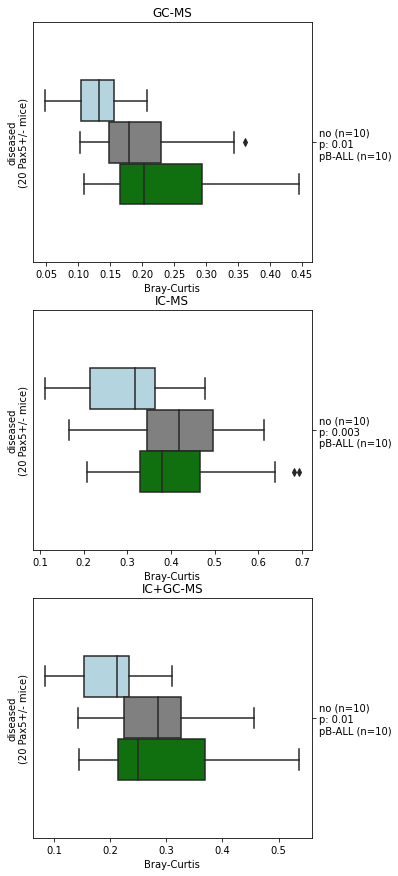

In [195]:
fig, axes = plt.subplots(3,1, figsize=(1*5, 3*5))
for i, method in enumerate(res_beta.keys()):
    field = 'diseased'
    field_meta = meta[meta['genotype'] == 'Pax5+/-'][field]
    b = detect_distant_groups(res_beta[method]['results']['bray_curtis'], 'Bray-Curtis', field_meta)
    ax, _ = plotGroup_permanovas(res_beta[method]['results']['bray_curtis'], field_meta, **b,
                                 horizontal=True, print_sample_numbers=True, colors_boxplot={'between': 'gray', 'left': 'lightblue', 'right': 'green'}, ax=axes[i])
    ax.set_ylabel(field+ "\n(%i Pax5+/- mice)" % field_meta.shape[0])
    ax.yaxis.label.set_visible(True)
    ax.set_title(method)
_savefig(fig, 'metabolome_beta_disease')

/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'diseased'  (n=30)
    16 (of   56) taxa different between 'pB-ALL' (n=10) vs. 'no' (n=10)



/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'diseased'  (n=37)
   155 (of  217) taxa different between 'pB-ALL' (n=10) vs. 'no' (n=10)



/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'diseased'  (n=30)
   176 (of  273) taxa different between 'pB-ALL' (n=10) vs. 'no' (n=10)



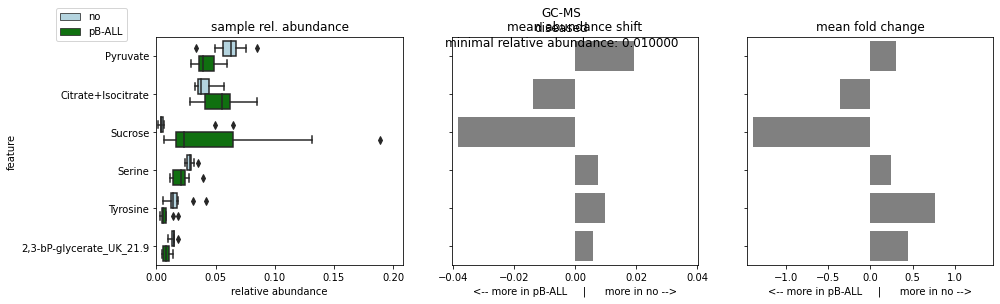

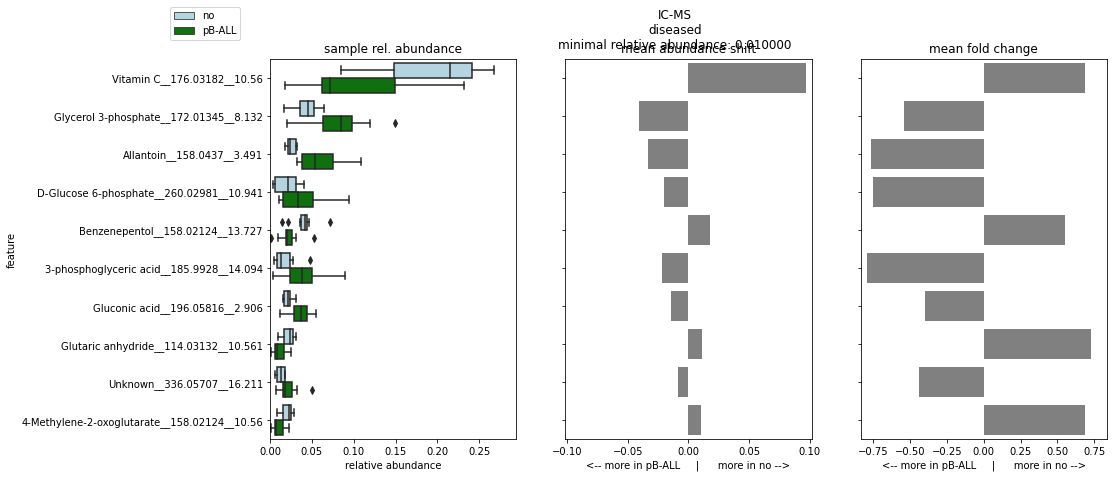

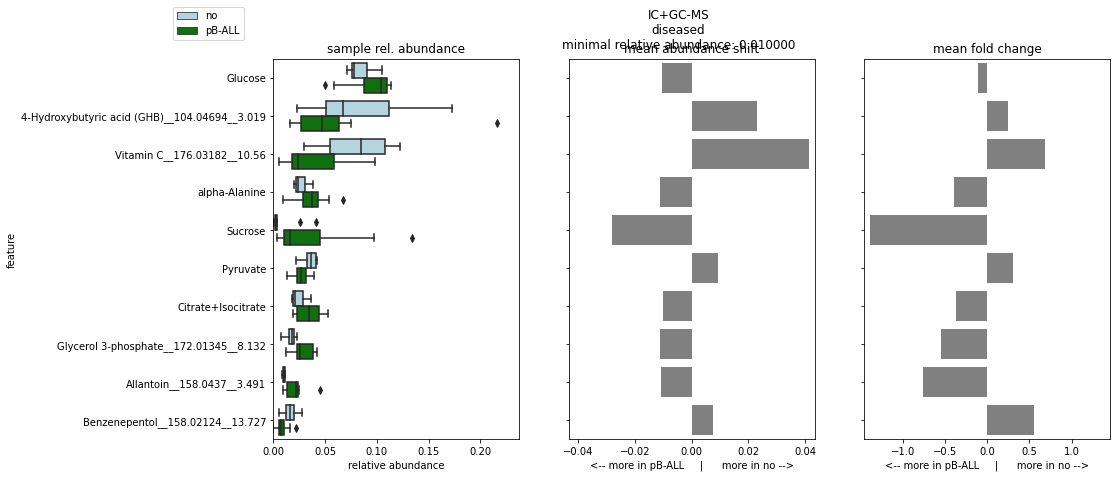

In [197]:
for method in res_beta.keys():
    res_dsFDR_diseased = find_diff_taxa(e[method], meta[meta['genotype'] == 'Pax5+/-'], ['diseased'])
    p = plot_diff_taxa(counts[method], meta[meta['genotype'] == 'Pax5+/-']['diseased'], res_dsFDR_diseased, min_mean_abundance=0.01,
                       title=method, topXfeatures=10,
                       colors_boxplot={'no': 'lightblue', 'pB-ALL': 'green'}, color_barplot='gray')
    _savefig(p[0], 'metabolome_dsfdr_disease_%s' % method)
    #_savefig(p[0], 'diffabund_diseased')
    #p[0]